In [1]:
import pandas as  pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import quandl
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error ,  r2_score
import datetime
from sklearn.model_selection import KFold
from tensorflow import keras

In [2]:
df = quandl.get("BCHARTS/BITSTAMPUSD", authtoken="4QxSz6Qa948RE7_PqsXw", collapse="daily")

In [3]:
df.reset_index(level=0, inplace=True)
df['Date']=df.Date.dt.strftime('%Y-%m-%d')

df = df.set_index('Date')

In [4]:
scores = pd.read_csv('final_score.csv').iloc[:, 1:].set_index('date')

scores


,sentiment
date,
2007-04-19,0.391667
2009-01-11,0.000000
2009-01-21,0.000000
2009-01-27,0.000000
2009-01-29,0.400000
...,...
2019-11-19,0.089968
2019-11-20,0.105519
2019-11-21,0.095096


In [5]:
df = df.merge(scores ,left_index=True , right_index=True )

In [6]:

df.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,sentiment
2011-09-20,4.92,5.66,4.92,5.66,89.280711,481.049263,5.388054,0.000000
2011-09-24,5.70,5.76,5.68,5.68,90.587066,518.383945,5.722494,0.000000
2011-09-29,4.81,4.82,4.81,4.82,46.964500,226.197226,4.816345,-0.125000
2011-10-08,4.57,4.57,3.99,3.99,56.000000,249.510000,4.455536,0.084091
2011-10-09,3.89,3.89,3.89,3.89,11.000000,42.790000,3.890000,0.300000


In [7]:
df.reset_index(level=0, inplace=True)

df['Date'] = df['index']
df = df.drop(columns=['index'])

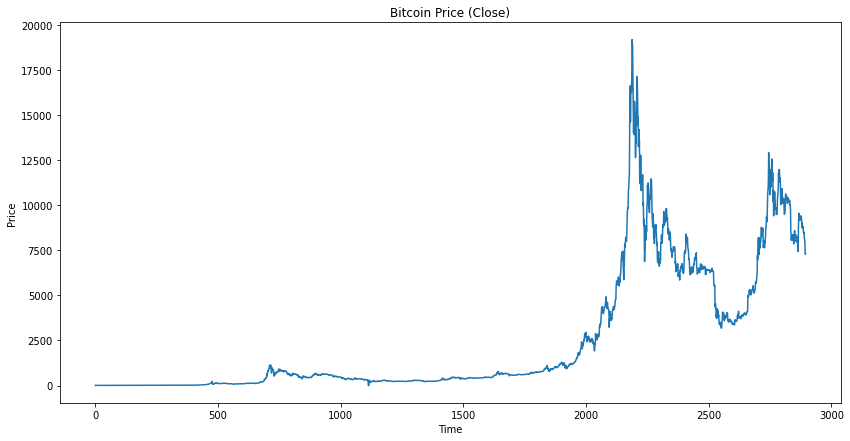

In [8]:
plt.figure(figsize=(14,7))
plt.plot( df['Close'])
plt.title('Bitcoin Price (Close)')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

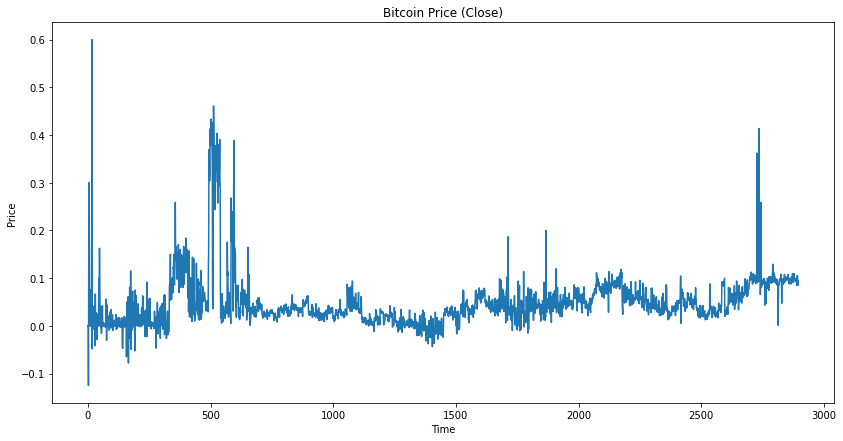

In [9]:
plt.figure(figsize=(14,7))
plt.plot( df['sentiment'])
plt.title('Bitcoin Price (Close)')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

In [10]:
data = df.drop(columns=['Date'])

data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,sentiment
0,4.92,5.66,4.92,5.66,89.280711,481.049263,5.388054,0.000000
1,5.70,5.76,5.68,5.68,90.587066,518.383945,5.722494,0.000000
2,4.81,4.82,4.81,4.82,46.964500,226.197226,4.816345,-0.125000
3,4.57,4.57,3.99,3.99,56.000000,249.510000,4.455536,0.084091
4,3.89,3.89,3.89,3.89,11.000000,42.790000,3.890000,0.300000


<AxesSubplot:title={'center':'Correlation entre les variables'}>

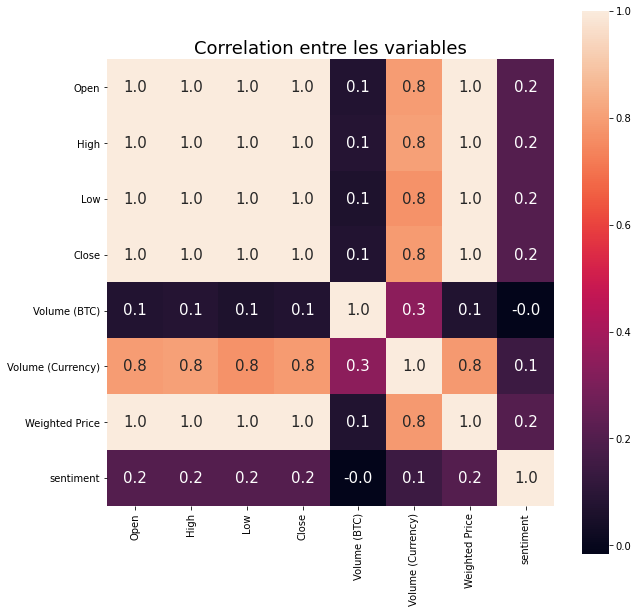

In [11]:
plt.figure(figsize=(10, 10))
plt.title("Correlation entre les variables", size=18)
sns.heatmap(data.corr(), square=True, fmt='.1f', annot=True, annot_kws={'size': 15})

## Trading indicatiors

#### MACD INDICATOR

In [12]:
def MACD(df):
    EMA12 = pd.DataFrame.ewm(df,span=12).mean()
    EMA26 = pd.DataFrame.ewm(df,span=26).mean()
    MACD  = EMA12 - EMA26
    
    Signal = pd.DataFrame.ewm(MACD,span=9).mean()
    
    Macd_Hist = MACD-Signal
    
    return Macd_Hist , MACD , Signal
    

In [13]:
MACD_hist , MACD , Signal =MACD(data["Close"])

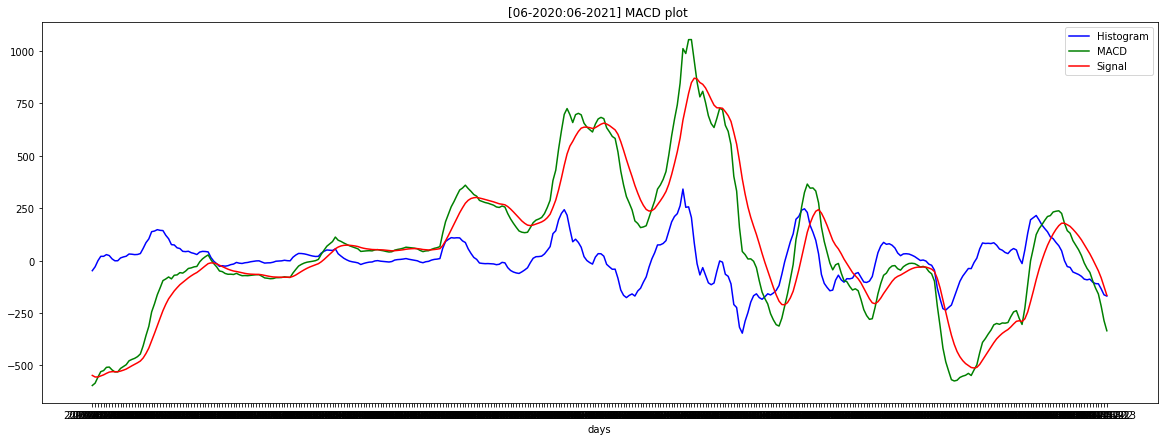

In [14]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].iloc[len(MACD_hist)-360 : len(MACD_hist)], MACD_hist[len(MACD_hist)-360 : len(MACD_hist)],color='b', label='Histogram')
plt.plot(df['Date'].iloc[len(MACD_hist)-360 : len(MACD_hist)], MACD[len(MACD_hist)-360 : len(MACD_hist)],color='g', label='MACD')
plt.plot(df['Date'].iloc[len(MACD_hist)-360 : len(MACD_hist)], Signal[len(MACD_hist)-360 : len(MACD_hist)],color='r', label='Signal')
plt.xlabel('days')
plt.legend()
plt.title("[06-2020:06-2021] MACD plot ")
plt.show()

####  Stochastics Oscillator

In [15]:
def Stoch_Oscillator(df):
    L14 = df['Low'].rolling(14).min()
    H14 = df['High'].rolling(14).max()
    K   =  (df['Close']- L14)*100/(H14 - L14)
    return K
    

In [16]:
K=Stoch_Oscillator(data)

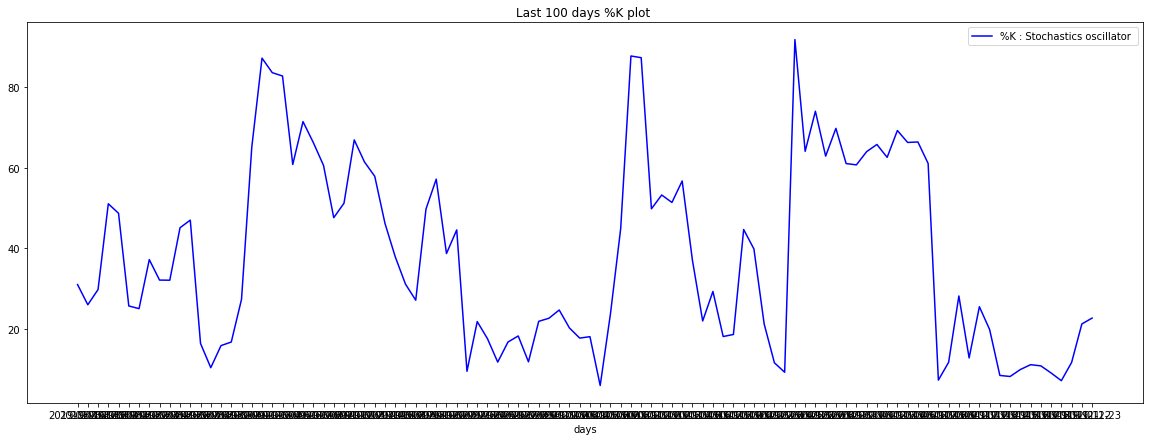

In [17]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].iloc[len(MACD_hist)-100 : len(MACD_hist)], K[len(MACD_hist)-100 : len(MACD_hist)],color='b', label='%K : Stochastics oscillator ')
plt.xlabel('days')
plt.legend()
plt.title("Last 100 days %K plot ")
plt.show()

#### Average true range

In [18]:
def Average_T_range(df):
    HL = df['High']-df['Low']
    HC = np.abs(df['High']-df['Close'].shift())
    LC =  np.abs(df['Low']-df['Close'].shift())
    ct = pd.concat([HL,HC,LC],axis=1)
    Tr = np.max(ct,axis=1) 
    ATR = Tr.rolling(14).mean()
    return ATR

In [19]:
atr = Average_T_range(data)

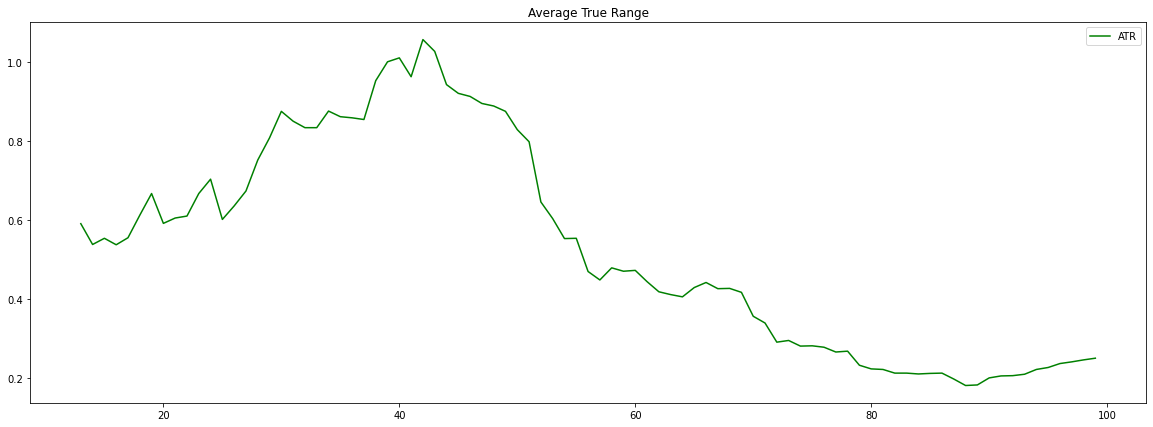

In [20]:
plt.figure(figsize=(20,7))
plt.plot(atr[0:100],label='ATR',color='green')
plt.title('Average True Range')
plt.legend()
plt.show()

### Getting final  data

In [21]:
data['MACD']= MACD_hist
data['%K']=K
data['ATR']=atr
data['Close Target'] = data['Close'].shift(-1)

data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,sentiment,MACD,%K,ATR,Close Target
0,4.92,5.66,4.92,5.66,89.280711,481.049263,5.388054,0.000000,0.000000,NaN,NaN,5.68
1,5.70,5.76,5.68,5.68,90.587066,518.383945,5.722494,0.000000,0.000199,NaN,NaN,4.82
2,4.81,4.82,4.81,4.82,46.964500,226.197226,4.816345,-0.125000,-0.015549,NaN,NaN,3.99
3,4.57,4.57,3.99,3.99,56.000000,249.510000,4.455536,0.084091,-0.037657,NaN,NaN,3.89
4,3.89,3.89,3.89,3.89,11.000000,42.790000,3.890000,0.300000,-0.044057,NaN,NaN,3.92


In [22]:
data = data.dropna().drop(columns=['Open','High','Low','Volume (BTC)','Volume (Currency)','Weighted Price'])

In [23]:
data.head()

,Close,sentiment,MACD,%K,ATR,Close Target
13,5.00,0.031309,0.127345,77.177177,0.590714,5.00
14,5.00,-0.000455,0.153703,77.177177,0.537857,5.29
15,5.29,0.000000,0.175469,98.961938,0.553571,5.57
16,5.57,0.600000,0.192798,100.000000,0.537143,6.65
17,6.65,-0.048377,0.246596,100.000000,0.555000,6.00


## Normalize data

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))

data = pd.DataFrame(scaler.fit_transform(data), columns=['Close','MACD','%K','ATR',  'sentiment','Close Target'])

data.head()

,Close,MACD,%K,ATR,sentiment,Close Target
0,0.000261,0.160948,0.541698,0.771772,0.000242,0.000261
1,0.000261,0.114083,0.541718,0.771772,0.000217,0.000276
2,0.000276,0.114754,0.541735,0.989619,0.000225,0.000290
3,0.000290,1.000000,0.541748,1.000000,0.000217,0.000347
4,0.000347,0.043379,0.541790,1.000000,0.000225,0.000313


## Initialize Model

In [25]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Close Target'])
y = data['Close Target']

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

In [26]:
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers

In [27]:
# timesteps data
def create_dataset(X,y,time_steps=1):
    X_train=[]
    y_train=[]
    for i in range(time_steps,X.shape[0]):
        X_train.append(X[i-time_steps:i])
        y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train , y_train

In [28]:
def test_set(X_train,X_test,y_train,y_test,time_steps=1):
    x=X_train.tail(time_steps)
    y= y_train.tail(time_steps)
    X_test=x.append(X_test,ignore_index=True)
    y_test=y.append(y_test,ignore_index=True)
    return create_dataset(X_test,y_test)

In [29]:
X_test , y_test = test_set(X_train,X_test,y_train,y_test)

In [30]:
X_train,y_train = create_dataset(X_train,y_train)

In [31]:
def model(hp):
    model = Sequential()
    model.add(layers.LSTM(units=hp.Int('units_input', 80, 120, step=10), return_sequences = True ,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(hp.Float('dropout_input', 0, 0.5, step=0.1, default=0.2)))
    n=hp.Int('number of hidden layers',2,6)
    for i in range(n):
        if i < n-1 :
            model.add(layers.LSTM(units=hp.Int('units_{0}'.format(i), 50, 90, step=10), return_sequences = True ))
            model.add(layers.Dropout(hp.Float('dropout_{0}'.format(i), 0, 0.5, step=0.1, default=0.2)))
        else : 
            model.add(layers.LSTM(units=hp.Int('units_{0}'.format(n-1), 50, 90, step=10)))
            model.add(layers.Dropout(hp.Float('dropout_{0}'.format(n-1), 0, 0.5, step=0.1, default=0.2)))
    model.add(layers.Dense(1))
    model.add(layers.Activation('linear'))
    model.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-6,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),metrics='mse')
    return model




#### Hyper-Parameters tuning

In [32]:
import kerastuner as kt

tuner = kt.Hyperband( model,
    objective='val_loss',
    max_epochs=30,
    hyperband_iterations=2,project_name='LSTM hyper-parameters2')

INFO:tensorflow:Reloading Oracle from existing project .\LSTM hyper-parameters2\oracle.json
INFO:tensorflow:Reloading Tuner from .\LSTM hyper-parameters2\tuner0.json


In [33]:
tuner.search(X_train ,  y_train , epochs = 20,validation_data=(X_test,y_test),shuffle = False)

INFO:tensorflow:Oracle triggered exit


In [34]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.get_best_models(1)[0]
seed = 7
np.random.seed(seed)
cvscores = []
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
indexes=[]

best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.get_best_models(1)[0]
X_t , y_t = create_dataset(X, y)
for train, test in kfold.split(X_t,y_t):
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(X_t[train], y_t[train], epochs=100,validation_data=(X_t[test],y_t[test]),shuffle=False,callbacks=[es_callback])
    cvscores.append(model.evaluate(X_t[test],y_t[test])[1])
    indexes.append([train,test])
best_split=cvscores.index(np.min(cvscores))
train = indexes[best_split][0]
test= indexes[best_split][1]




Epoch 1/100
81/81 [==============================] - 6s 22ms/step - loss: 0.0863 - mse: 0.0212 - val_loss: 0.2563 - val_mse: 0.0769
Epoch 2/100
81/81 [==============================] - 0s 4ms/step - loss: 0.1290 - mse: 0.0345 - val_loss: 0.1881 - val_mse: 0.0424
Epoch 3/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0993 - mse: 0.0194 - val_loss: 0.1439 - val_mse: 0.0217
Epoch 4/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0745 - mse: 0.0111 - val_loss: 0.1645 - val_mse: 0.0285
Epoch 5/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0749 - mse: 0.0116 - val_loss: 0.1285 - val_mse: 0.0188
Epoch 6/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0801 - mse: 0.0130 - val_loss: 0.1466 - val_mse: 0.0256
Epoch 7/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0812 - mse: 0.0130 - val_loss: 0.1168 - val_mse: 0.0163
Epoch 8/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0697 - 

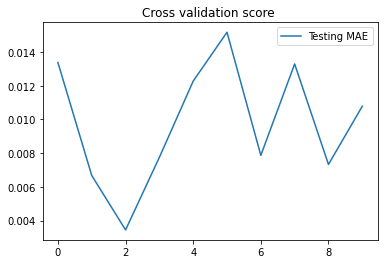

In [48]:
plt.plot(cvscores, label = 'Testing MAE')
plt.title ( 'Cross validation score ')
plt.legend()
plt.show()

In [44]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(X_t[train], y_t[train], epochs=100,validation_data=(X_t[test],y_t[test]),shuffle=False,callbacks=[es_callback,tensorboard_callback])

%load_ext tensorboard
%tensorboard --logdir logs

Epoch 1/100
82/82 [==============================] - 3s 42ms/step - loss: 0.0439 - mse: 0.0055 - val_loss: 0.0297 - val_mse: 0.0014
Epoch 2/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0481 - mse: 0.0066 - val_loss: 0.0947 - val_mse: 0.0110
Epoch 3/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0466 - mse: 0.0056 - val_loss: 0.0649 - val_mse: 0.0055
Epoch 4/100
82/82 [==============================] - 0s 4ms/step - loss: 0.0460 - mse: 0.0053 - val_loss: 0.0590 - val_mse: 0.0043
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12188), started 3:41:39 ago. (Use '!kill 12188' to kill it.)

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 90)             34560     
_________________________________________________________________
dropout (Dropout)            (None, 1, 90)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 70)             45080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 70)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                31440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

<Figure size 1440x504 with 0 Axes>

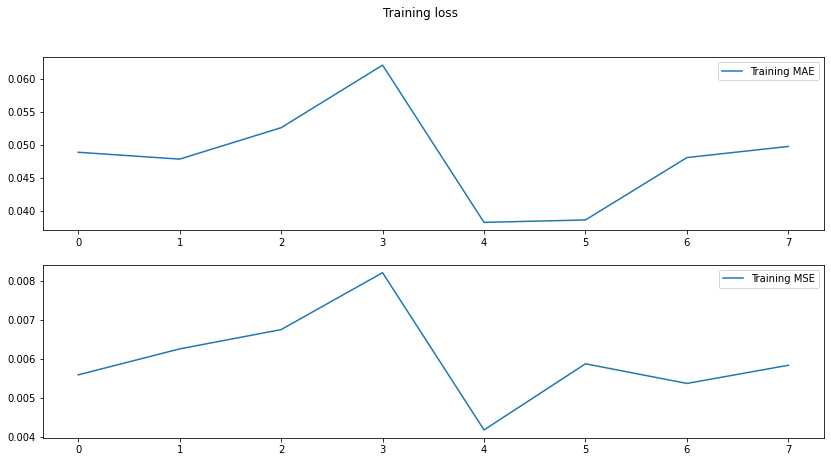

In [36]:
plt.figure(figsize=(20,7))

f ,(ax1, ax2) = plt.subplots(2, 1,figsize=(14,7))
ax1.plot(history.history['loss'],   label= 'Training MAE')
ax2.plot(history.history['mse'],   label= 'Training MSE')
f.suptitle("Training loss")
ax1.legend()
ax2.legend()
plt.show()
f.savefig("Training loss2.png")

In [37]:
y_pred = model.predict(X_t[test])


In [38]:
y_pred_inv=(1/scaler.scale_[len(scaler.scale_)-1])*y_pred

In [39]:
y_test_inv=(1/scaler.scale_[len(scaler.scale_)-1])*y_t[test]

In [40]:
score= r2_score(y_test_inv,y_pred_inv)
print ( 'R2 score : {0:.3f} \n'.format(score))

R2 score : 0.837 



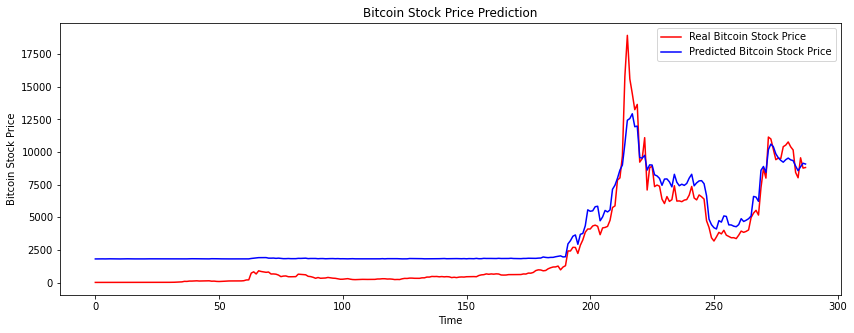

In [41]:
plt.figure(figsize=(14,5))
plt.plot(y_test_inv, color = 'red', label = 'Real Bitcoin Stock Price')
plt.plot(y_pred_inv, color = 'blue', label = 'Predicted Bitcoin Stock Price')
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()

In [42]:
x_all,y_all = create_dataset(X,y)
all_pred=model.predict(x_all)

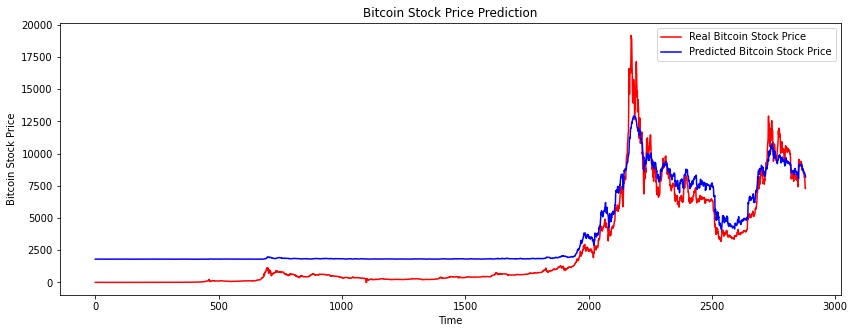

In [43]:
plt.figure(figsize=(14,5))
plt.plot((1/scaler.scale_[len(scaler.scale_)-1])*y_all, color = 'red', label = 'Real Bitcoin Stock Price')
plt.plot((1/scaler.scale_[len(scaler.scale_)-1])*all_pred, color = 'blue', label = 'Predicted Bitcoin Stock Price')
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()